In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import scikit_posthocs as sp
import matplotlib.pyplot as plt
from scipy.stats import friedmanchisquare
from utils import plot_barscatter_ax, format_column

In [2]:
results = pd.read_csv('results/binary/results.csv')

In [3]:
methods = {
    'Isotonic regression': 'iso',
    'TS (probmetrics)':    'prob_ts',
    'TS (Guo et al.)':     'guo_ts',
    'TS (ours)':           'ts',
    'Affine scaling':      'as',
    'Quadratic scaling':   'qs'
}

palette = {
    'TS (Guo et al.)': '#d62728',
    'TS (probmetrics)': '#1f77b4',
    'TS (ours)': '#2ca02c',
    'Affine scaling': '#ff7f0e',
    'Quadratic scaling': '#9467bd',
    'Isotonic regression': '#8c564b',
    'No calibration': '#7f7f7f',
}

palette_pastel = {
    'TS (Guo et al.)': '#ff9f9b',
    'TS (probmetrics)': '#a1c9f4',
    'TS (ours)': '#8de5a1',
    'Affine scaling': '#ffb482',
    'Quadratic scaling': '#d0bbff',
    'Isotonic regression': '#debb9b',
    'No calibration': '#cfcfcf',
}

## Average score tables

In [4]:
base_brier = results.base_brier.mean()
base_logloss = results.base_logloss.mean()

print('Mean Brier score absolute improvement:')
print(f'Isotonic regression: {results.iso_brier.mean() - base_brier:.5f}')
print(f'TS (ours):           {results.ts_brier.mean() - base_brier:.5f}')
print(f'TS (probmetrics):    {results.prob_ts_brier.mean() - base_brier:.5f}')
print(f'TS (Guo et al.):     {results.guo_ts_brier.mean() - base_brier:.5f}')
print(f'Affine scaling:      {results.as_brier.mean() - base_brier:.5f}')
print(f'Quadratic scaling:   {results.qs_brier.mean() - base_brier:.5f}')
print()
print('Mean logloss absolute improvement:')
print(f'Isotonic regression: {results.iso_logloss.mean() - base_logloss:.5f}')
print(f'TS (ours):           {results.ts_logloss.mean() - base_logloss:.5f}')
print(f'TS (probmetrics):    {results.prob_ts_logloss.mean() - base_logloss:.5f}')
print(f'TS (Guo et al.):     {results.guo_ts_logloss.mean() - base_logloss:.5f}')
print(f'Affine scaling:      {results.as_logloss.mean() - base_logloss:.5f}')
print(f'Quadratic scaling:   {results.qs_logloss.mean() - base_logloss:.5f}')
print()
print('Total runtime:')
print(f'Isotonic regression: {results.iso_time.sum():.5f}')
print(f'TS (ours):           {results.ts_time.sum():.5f}')
print(f'TS (probmetrics):    {results.prob_ts_time.sum():.5f}')
print(f'TS (Guo et al.):     {results.guo_ts_time.sum():.5f}')
print(f'Affine scaling:      {results.as_time.sum():.5f}')
print(f'Quadratic scaling:   {results.qs_time.sum():.5f}')

Mean Brier score absolute improvement:
Isotonic regression: -0.00253
TS (ours):           -0.00185
TS (probmetrics):    -0.00182
TS (Guo et al.):     0.00635
Affine scaling:      -0.00262
Quadratic scaling:   -0.00342

Mean logloss absolute improvement:
Isotonic regression: 0.09092
TS (ours):           -0.01417
TS (probmetrics):    -0.01674
TS (Guo et al.):     0.00427
Affine scaling:      -0.01543
Quadratic scaling:   -0.01809

Total runtime:
Isotonic regression: 2.48982
TS (ours):           2.15517
TS (probmetrics):    8.53484
TS (Guo et al.):     44.37813
Affine scaling:      19.35412
Quadratic scaling:   35.12515


Latex format

In [5]:
# Calculate Base Means
base_brier = results.base_brier.mean()
base_logloss = results.base_logloss.mean()

data = []

# Iterate through methods and calculate differences
for name, prefix in methods.items():
    # Calculate difference (Method - Base)
    brier_diff = getattr(results, f'{prefix}_brier').mean() - base_brier
    ll_diff = getattr(results, f'{prefix}_logloss').mean() - base_logloss
    
    data.append({
        'Method': name,
        'Brier score gap': brier_diff,
        'Logloss gap': ll_diff
    })

# Create a DataFrame
df = pd.DataFrame(data)

# Apply formatting
df['Brier score gap'] = format_column(df['Brier score gap'])
df['Logloss gap'] = format_column(df['Logloss gap'])

# Generate LaTeX code
latex_code = df.to_latex(index=False, escape=False, caption="Mean absolute gap to base model", label="tab:calibration_results")

print(latex_code)

\begin{table}
\caption{Mean absolute gap to base model}
\label{tab:calibration_results}
\begin{tabular}{lll}
\toprule
Method & Brier score gap & Logloss gap \\
\midrule
Isotonic regression & -0.0025 & 0.0909 \\
TS (probmetrics) & -0.0018 & -0.0167 \\
TS (Guo et al.) & 0.0063 & 0.0043 \\
TS (ours) & -0.0018 & -0.0142 \\
Affine scaling & -0.0026 & -0.0154 \\
Quadratic scaling & \textbf{-0.0034} & \textbf{-0.0181} \\
\bottomrule
\end{tabular}
\end{table}



## Critical difference diagrams

Brier score improvement analysis

In [6]:
df = results[['dataset']].copy()
df['Isotonic regression'] = results['iso_brier'] - results['base_brier']
df['TS (probmetrics)'] = results['prob_ts_brier'] - results['base_brier']
df['TS (ours)'] = results['ts_brier'] - results['base_brier']
df['Affine scaling'] = results['as_brier'] - results['base_brier']
df['Quadratic scaling'] = results['qs_brier'] - results['base_brier']
df['No calibration'] = 0
df = df.groupby('dataset').mean().reset_index()
df = df.drop('dataset', axis=1)

In [7]:
stat, p_value = friedmanchisquare(*[df[col] for col in df.columns])

print(f"\nFriedman Test Statistic: {stat:.3f}")
print(f"P-Value: {p_value:.5e}")

if p_value < 0.05:
    print("Result: Significant difference found. Proceeding to Nemenyi test.")
else:
    print("Result: No significant difference found. Stop here.")


Friedman Test Statistic: 101.692
P-Value: 2.32431e-20
Result: Significant difference found. Proceeding to Nemenyi test.


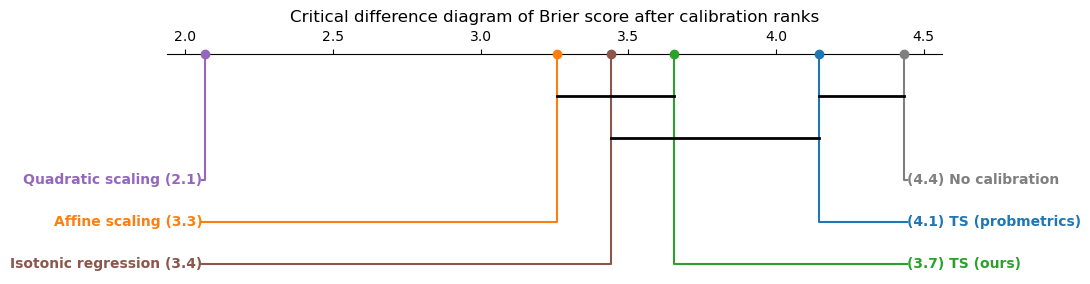

In [8]:
nemenyi_results = sp.posthoc_nemenyi_friedman(df)

ranks = df.rank(axis=1, method='average')
avg_ranks = ranks.mean(axis=0)

plt.figure(figsize=(10, 3))
plt.title('Critical difference diagram of Brier score after calibration ranks')
graph = sp.critical_difference_diagram(ranks=avg_ranks, sig_matrix=nemenyi_results, label_props={'fontweight': 'bold'}, color_palette=palette)
plt.savefig(f'figures/binary_critical_diff_brier.pdf', bbox_inches='tight')
plt.show()

Logloss improvement analysis

In [9]:
df = results[['dataset']].copy()
df['Isotonic regression'] = results['iso_logloss'] - results['base_logloss']
df['TS (probmetrics)'] = results['prob_ts_logloss'] - results['base_logloss']
df['TS (ours)'] = results['ts_logloss'] - results['base_logloss']
df['Affine scaling'] = results['as_logloss'] - results['base_logloss']
df['Quadratic scaling'] = results['qs_logloss'] - results['base_logloss']
df['No calibration'] = 0
df = df.groupby('dataset').mean().reset_index()
df = df.drop('dataset', axis=1)

In [10]:
stat, p_value = friedmanchisquare(*[df[col] for col in df.columns])

print(f"\nFriedman Test Statistic: {stat:.3f}")
print(f"P-Value: {p_value:.5e}")

if p_value < 0.05:
    print("Result: Significant difference found. Proceeding to Nemenyi test.")
else:
    print("Result: No significant difference found. Stop here.")


Friedman Test Statistic: 209.725
P-Value: 2.35628e-43
Result: Significant difference found. Proceeding to Nemenyi test.


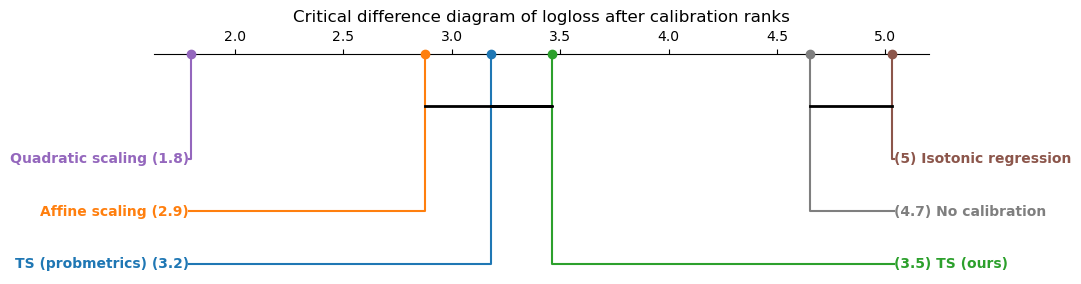

In [11]:
nemenyi_results = sp.posthoc_nemenyi_friedman(df)

ranks = df.rank(axis=1, method='average')
avg_ranks = ranks.mean(axis=0)

plt.figure(figsize=(10, 3))
plt.title('Critical difference diagram of logloss after calibration ranks')
graph = sp.critical_difference_diagram(ranks=avg_ranks, sig_matrix=nemenyi_results, label_props={'fontweight': 'bold'}, color_palette=palette)
plt.savefig(f'figures/binary_critical_diff_logloss.pdf', bbox_inches='tight')
plt.show()

## Relative difference plots

In [12]:
df = pd.DataFrame()

df['dataset'] = results.dataset

for metric in ['brier', 'logloss', 'ece-15']:
    # "rel" stands for relative improvement (measured in %)
    base = results[f'base_{metric}']
    df[f'iso_{metric}_rel'] = 100.0 * (results[f'iso_{metric}'] / base - 1.0)
    df[f'guo_ts_{metric}_rel'] = 100.0 * (results[f'guo_ts_{metric}'] / base - 1.0)
    df[f'prob_ts_{metric}_rel'] = 100.0 * (results[f'prob_ts_{metric}'] / base - 1.0)
    df[f'ts_{metric}_rel'] = 100.0 * (results[f'ts_{metric}'] / base - 1.0)
    df[f'as_{metric}_rel'] = 100.0 * (results[f'as_{metric}'] / base - 1.0)
    df[f'qs_{metric}_rel'] = 100.0 * (results[f'qs_{metric}'] / base - 1.0)

df = df.groupby('dataset').agg('mean')

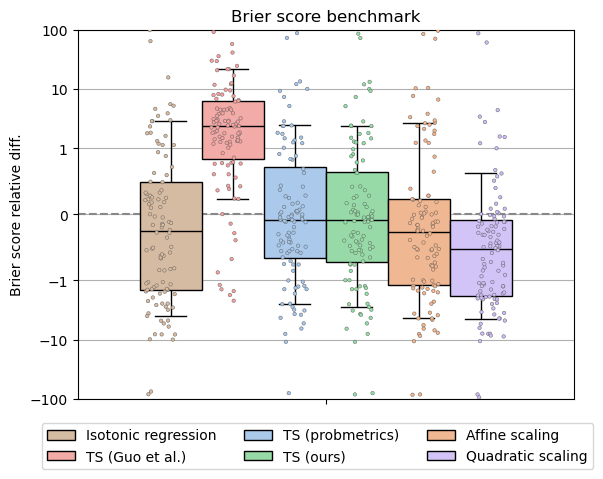

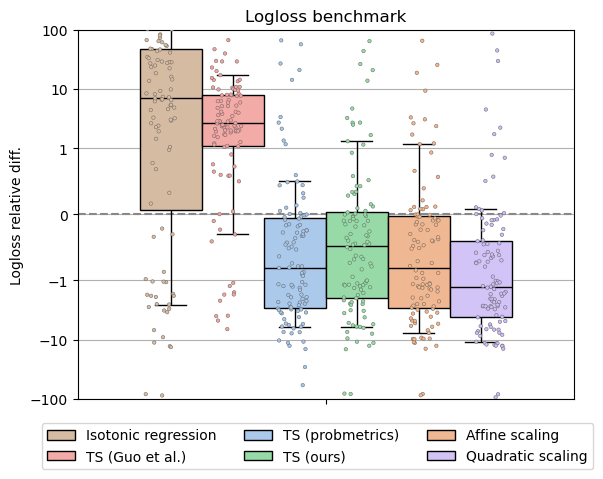

In [13]:
for (metric, name) in [('brier', 'Brier score'), ('logloss', 'Logloss')]:

    table = pd.DataFrame(columns=['hue', 'label', 'value'])
    for i in range(len(df)):
        table.loc[len(table)] = ['Isotonic regression', '', df.iloc[i][f'iso_{metric}_rel']]
        table.loc[len(table)] = ['TS (Guo et al.)', '', df.iloc[i][f'guo_ts_{metric}_rel']]
        table.loc[len(table)] = ['TS (probmetrics)', '', df.iloc[i][f'prob_ts_{metric}_rel']]
        table.loc[len(table)] = ['TS (ours)', '', df.iloc[i][f'ts_{metric}_rel']]
        table.loc[len(table)] = ['Affine scaling', '', df.iloc[i][f'as_{metric}_rel']]
        table.loc[len(table)] = ['Quadratic scaling', '', df.iloc[i][f'qs_{metric}_rel']]

    fig, ax = plt.subplots()
    plot_barscatter_ax(ax, table, title=f'{name} benchmark', ylabel=f'{name} relative diff.', palette=palette_pastel)
    plt.ylim((-100.0, 100.0))

    # Coordinates where the arrow will point
    x_arrow = 1.5
    y_arrow = -30.0

    # Add downward arrow and text
    ax.annotate(
        'lower is better',
        xy=(x_arrow, y_arrow), # arrow tip
        xytext=(0, 30),
        textcoords='offset points',
        arrowprops=dict(facecolor='black', shrink=0.05, width=.5, headwidth=8),
        fontsize=10,
        ha='center',
        va='bottom'
    )

    handles, labels = plt.gca().get_legend_handles_labels()
    plt.figlegend(
        handles,
        ('Isotonic regression', 'TS (Guo et al.)', 'TS (probmetrics)', 'TS (ours)', 'Affine scaling', 'Quadratic scaling'),
        loc='lower center',
        bbox_to_anchor=(0.5, -.05),
        ncol=3
    )

    plt.savefig(f'figures/binary_benchmark_{metric}.pdf', bbox_inches='tight')
    plt.show()

In [14]:
df = pd.DataFrame()

df['dataset'] = results.dataset
df['model'] = results.config.str.split('_').str[0]

for metric in ['brier', 'logloss', 'ece-15']:
    # "rel" stands for relative improvement (measured in %)
    base = results[f'base_{metric}']
    df[f'iso_{metric}_rel'] = 100.0 * (results[f'iso_{metric}'] / base - 1.0)
    df[f'guo_ts_{metric}_rel'] = 100.0 * (results[f'guo_ts_{metric}'] / base - 1.0)
    df[f'prob_ts_{metric}_rel'] = 100.0 * (results[f'prob_ts_{metric}'] / base - 1.0)
    df[f'ts_{metric}_rel'] = 100.0 * (results[f'ts_{metric}'] / base - 1.0)
    df[f'as_{metric}_rel'] = 100.0 * (results[f'as_{metric}'] / base - 1.0)
    df[f'qs_{metric}_rel'] = 100.0 * (results[f'qs_{metric}'] / base - 1.0)

df = df.groupby(['dataset', 'model']).agg('mean').reset_index()

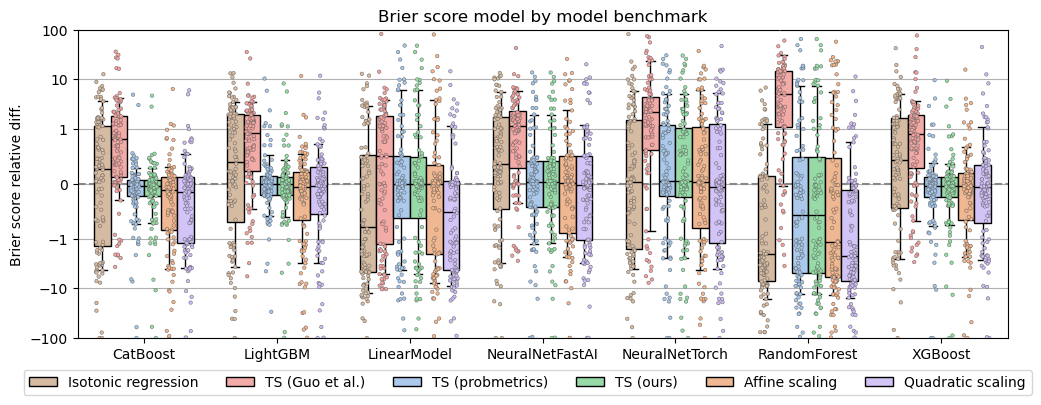

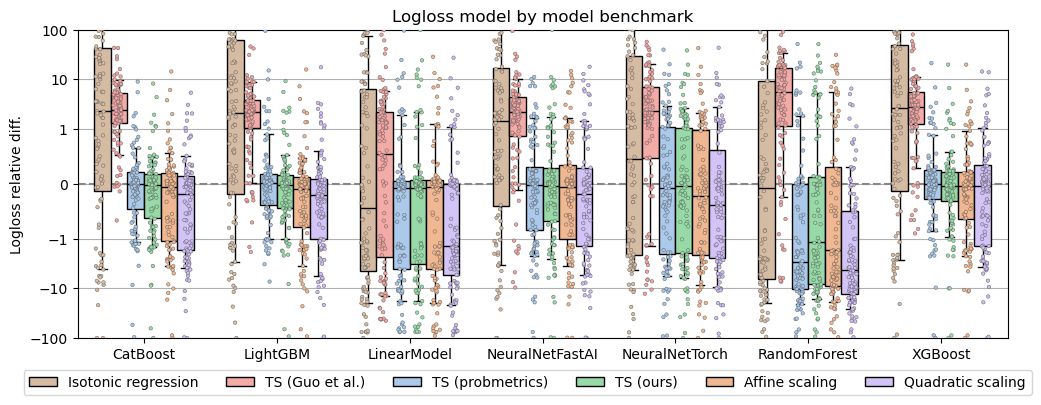

In [15]:
for (metric, name) in [('brier', 'Brier score'), ('logloss', 'Logloss')]:

    table = pd.DataFrame(columns=['hue', 'label', 'value'])
    for i in range(len(df)):
        table.loc[len(table)] = ['Isotonic regression', df.iloc[i].model, df.iloc[i][f'iso_{metric}_rel']]
        table.loc[len(table)] = ['TS (Guo et al.)', df.iloc[i].model, df.iloc[i][f'guo_ts_{metric}_rel']]
        table.loc[len(table)] = ['TS (probmetrics)', df.iloc[i].model, df.iloc[i][f'prob_ts_{metric}_rel']]
        table.loc[len(table)] = ['TS (ours)', df.iloc[i].model, df.iloc[i][f'ts_{metric}_rel']]
        table.loc[len(table)] = ['Affine scaling', df.iloc[i].model, df.iloc[i][f'as_{metric}_rel']]
        table.loc[len(table)] = ['Quadratic scaling', df.iloc[i].model, df.iloc[i][f'qs_{metric}_rel']]

    fig, ax = plt.subplots(figsize=(12,4))
    plot_barscatter_ax(ax, table, title=f'{name} model by model benchmark', ylabel=f'{name} relative diff.', palette=palette_pastel)
    plt.ylim((-100.0, 100.0))

    handles, labels = plt.gca().get_legend_handles_labels()
    plt.figlegend(
        handles,
        ('Isotonic regression', 'TS (Guo et al.)', 'TS (probmetrics)', 'TS (ours)', 'Affine scaling', 'Quadratic scaling'),
        loc='lower center',
        bbox_to_anchor=(0.5, -.05),
        ncol=6
    )

    plt.savefig(f'figures/binary_model_benchmark_{metric}.pdf', bbox_inches='tight')
    plt.show()

## Fitting times

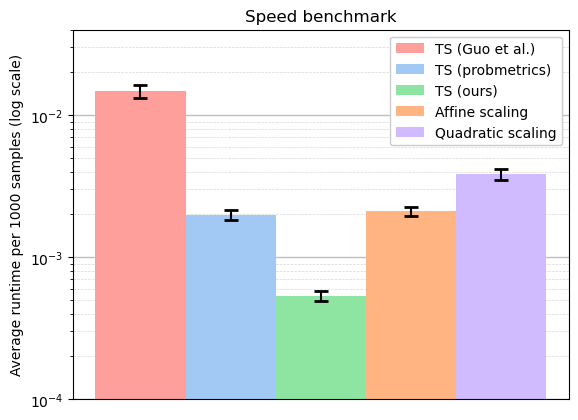

In [16]:
# Prepare data
times = {}
n = len(results)
for method in ['guo_ts', 'prob_ts', 'ts', 'as', 'qs']:
    # Average time per 1000 samples.
    times[f'{method}_mean'] = (1000.0 * results[f'{method}_time'] / results.cal_size).mean()
    times[f'{method}_err'] = 1.96 * (1000.0 * results[f'{method}_time'] / results.cal_size).std() / np.sqrt(n / 3)

fig, ax = plt.subplots()

width = 0.2

# Bar plot: runtime (log scale)
ax.bar(0 - 2.0*width, times['guo_ts_mean'], width, color=palette_pastel['TS (Guo et al.)'], label='TS (Guo et al.)')
ax.errorbar(0 - 2.0*width, times['guo_ts_mean'], yerr=times['guo_ts_err'], color='black', capsize=5, capthick=2)

ax.bar(0 - 1.0*width, times['prob_ts_mean'], width, color=palette_pastel['TS (probmetrics)'], label='TS (probmetrics)')
ax.errorbar(0 - 1.0*width, times['prob_ts_mean'], yerr=times['prob_ts_err'], color='black', capsize=5, capthick=2)

ax.bar(0 + 0.0*width, times['ts_mean'], width, color=palette_pastel['TS (ours)'], label='TS (ours)')
ax.errorbar(0 + 0.0*width, times['ts_mean'], yerr=times['ts_err'], color='black', capsize=5, capthick=2)

ax.bar(0 + 1.0*width, times['as_mean'], width, color=palette_pastel['Affine scaling'], label='Affine scaling')
ax.errorbar(0 + 1.0*width, times['as_mean'], yerr=times['as_err'], color='black', capsize=5, capthick=2)

ax.bar(0 + 2.0*width, times['qs_mean'], width, color=palette_pastel['Quadratic scaling'], label='Quadratic scaling')
ax.errorbar(0 + 2.0*width, times['qs_mean'], yerr=times['qs_err'], color='black', capsize=5, capthick=2)

ax.grid(True, axis='y', which='minor', linestyle='--', linewidth=0.5, alpha=0.5)
ax.grid(True, axis='y', which='major', linestyle='-', linewidth=1.0, alpha=0.8)
ax.set_axisbelow(True)

ax.set_ylim(bottom=1e-4, top=0.04)
ax.set_xticks([])
ax.set_yscale('log')
ax.set_ylabel('Average runtime per 1000 samples (log scale)')
ax.set_title('Speed benchmark')

leg = ax.legend()
leg.get_frame().set_alpha(1.0)

plt.savefig('figures/binary_benchmark_time.pdf', bbox_inches='tight')
plt.show()

In [17]:
len(results)

2184

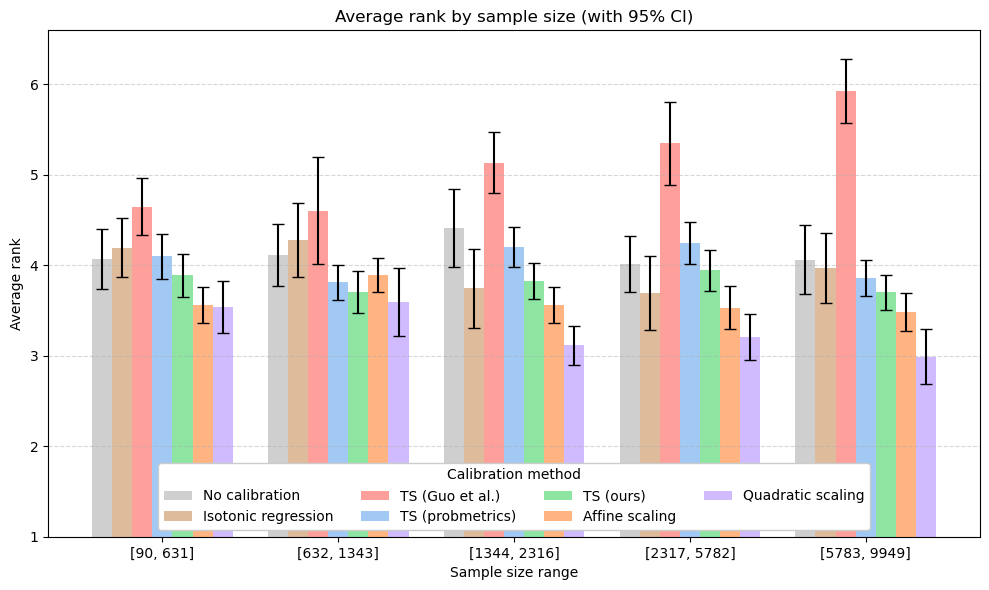

In [18]:
df = results[results.cal_size < 10000].copy()

df['No calibration'] = 0
df['Isotonic regression'] = df['iso_brier'] - df['base_brier']
df['TS (Guo et al.)'] = df['guo_ts_brier'] - df['base_brier']
df['TS (probmetrics)'] = df['prob_ts_brier'] - df['base_brier']
df['TS (ours)'] = df['ts_brier'] - df['base_brier']
df['Affine scaling'] = df['as_brier'] - df['base_brier']
df['Quadratic scaling'] = df['qs_brier'] - df['base_brier']

cols = ['No calibration', 'Isotonic regression', 'TS (Guo et al.)', 'TS (probmetrics)', 'TS (ours)', 'Affine scaling', 'Quadratic scaling']
ranks = df[cols].rank(axis=1, ascending=True)

df = pd.concat([df[['dataset', 'cal_size']], ranks], axis=1)

df = df.groupby('dataset').mean().reset_index()

df['quantile_bin'] = pd.qcut(df['cal_size'], q=5)

grouped = df.groupby('quantile_bin', observed=False)
means = grouped[cols].mean()
sems = grouped[cols].sem()
conf_intervals = sems * 1.96

ax = means.plot(kind='bar', yerr=conf_intervals, figsize=(10, 6), width=0.8, capsize=4, color=palette_pastel)
labels = [f"[{int(i.left+1)}, {int(i.right)}]" for i in means.index]
ax.set_xticklabels(labels, rotation=0)

plt.title('Average rank by sample size (with 95% CI)')
plt.ylabel('Average rank')
plt.xlabel('Sample size range')
plt.ylim(bottom=1)

plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend(loc='lower center', title='Calibration method', ncols=4, framealpha=1.0)
plt.tight_layout()

plt.savefig(f'figures/binary_benchmark_sample_effect.pdf', bbox_inches='tight')
plt.show()